## Exploring Survival On The Titanic (Python) - cont
#### Converting into python, from r, some of the ideas from Megan Risdals brilliant analysis - https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic/comments to see if I can improve my score.

- Missing Value Imputation
- Prediction

In [63]:
# Import libraries

import numpy as np
from numpy.random import random_integers
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

print('Libraries Ready!')

Libraries Ready!


In [64]:
# Load the full training and test dataset, saved to csv on day58
full = pd.read_csv('/home/sophie/Python/notechain/Titanic/data/058_full.csv', header=0)

In [65]:
print(list(full))
print(full.count())
print(full.head())

['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title', 'Surname', 'FamSize', 'FamSize_D', 'Survive_txt', 'Deck']
Age            1046
Cabin           295
Embarked       1309
Fare           1308
Name           1309
Parch          1309
PassengerId    1309
Pclass         1309
Sex            1309
SibSp          1309
Survived        891
Ticket         1309
Title          1309
Surname        1309
FamSize        1309
FamSize_D      1309
Survive_txt     891
Deck            289
dtype: int64
    Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2   

In [66]:
# Show number of missing Age values
len(full[full['Age'].isnull()])

263

We could definitely use rpart (recursive partitioning for regression) to predict missing ages, but I’m going to use the mice package for this task just for something different. You can read more about multiple imputation using chained equations in r here (PDF). Since we haven’t done it yet, I’ll first factorize the factor variables and then perform mice imputation.

In [67]:
# Which variables need to be converted into dummies?
print(full[['Pclass','Sex','Embarked','Title','Surname','FamSize','FamSize_D']].dtypes)
print(full[['Pclass','Sex','Embarked','Title','Surname','FamSize','FamSize_D']][0:3])

# don't need to convert Pclass or FamSize to dummies. We can use FamSize instead of FamSize_D
# Going to miss out surname too as this will give us loads more columns.

Pclass        int64
Sex          object
Embarked     object
Title        object
Surname      object
FamSize       int64
FamSize_D    object
dtype: object
   Pclass     Sex Embarked Title    Surname  FamSize     FamSize_D
0       3    male        S    Mr     Braund        2  Small Family
1       1  female        C   Mrs    Cumings        2  Small Family
2       3  female        S  Miss  Heikkinen        1        Single


In [68]:
# get the columns in the right format. Megan uses 'PassengerId','Pclass','Sex','Embarked','Title',
# 'Surname','Family','FsizeD'
dummies_Sex = pd.get_dummies(full['Sex'], prefix='Sex')
dummies_Embarked = pd.get_dummies(full['Embarked'], prefix= 'Embarked') 
dummies_Title = pd.get_dummies(full['Title'], prefix= 'Title')


In [69]:
print(list(dummies_Sex))
print(list(dummies_Embarked))
print(list(dummies_Title))
# Add these a new data frame with dummies
full_dums = pd.concat([full, dummies_Sex, dummies_Embarked, dummies_Title], axis=1)
print(list(full_dums))

['Sex_female', 'Sex_male']
['Embarked_C', 'Embarked_Q', 'Embarked_S']
['Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']
['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title', 'Surname', 'FamSize', 'FamSize_D', 'Survive_txt', 'Deck', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']


In [70]:
# Now drop the Sex, Embarked and Title original columns
full_dums = full_dums.drop(['Title','Sex','Embarked'], axis=1)

In [71]:
print(list(full_dums))
print(full_dums.dtypes)
print(full_dums.count())

['Age', 'Cabin', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'SibSp', 'Survived', 'Ticket', 'Surname', 'FamSize', 'FamSize_D', 'Survive_txt', 'Deck', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']
Age             float64
Cabin            object
Fare            float64
Name             object
Parch             int64
PassengerId       int64
Pclass            int64
SibSp             int64
Survived        float64
Ticket           object
Surname          object
FamSize           int64
FamSize_D        object
Survive_txt      object
Deck             object
Sex_female      float64
Sex_male        float64
Embarked_C      float64
Embarked_Q      float64
Embarked_S      float64
Title_Master    float64
Title_Miss      float64
Title_Mr        float64
Title_Mrs       float64
Title_Rare      float64
dtype: object
Age             1046
Cabin            295
Fare            1308
Name            1309
Parch    

In [72]:
# Make a dataframe with just the columns we want to pass to MICE
# drop some more columns
full_dums = full_dums[['Age', 'Fare', 'Parch','Pclass', 'SibSp', 'Survived', 'FamSize', 
                            'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master',
                            'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']].astype(float)
# Turn all to floats. Didn't fix.

In [73]:
full_dums = full_dums[['Age', 'Parch','Pclass', 'SibSp', 'FamSize', 
                            'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master',
                            'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']].astype(float) 

In [74]:
# Make another dataFrame with just complete values
print(full_dums.count())
print(full_dums.max())

Age             1046
Parch           1309
Pclass          1309
SibSp           1309
FamSize         1309
Sex_female      1309
Sex_male        1309
Embarked_C      1309
Embarked_Q      1309
Embarked_S      1309
Title_Master    1309
Title_Miss      1309
Title_Mr        1309
Title_Mrs       1309
Title_Rare      1309
dtype: int64
Age             80.0
Parch            9.0
Pclass           3.0
SibSp            8.0
FamSize         11.0
Sex_female       1.0
Sex_male         1.0
Embarked_C       1.0
Embarked_Q       1.0
Embarked_S       1.0
Title_Master     1.0
Title_Miss       1.0
Title_Mr         1.0
Title_Mrs        1.0
Title_Rare       1.0
dtype: float64


In [75]:
# Trying a much smaller array

In [76]:
print(full_dums.shape)

(1309, 15)


In [77]:
from fancyimpute import MICE, SimpleFill, SoftImpute,IterativeSVD,MatrixFactorization


solver = SoftImpute(verbose=False)

#apply SoftImpute
full_SI = solver.complete(full_dums)

In [79]:
solver = MICE()

#apply SoftImpute
full_MICE = solver.complete(full_dums)

[MICE] Completing matrix with shape (1309, 15)
[MICE] Starting imputation round 1/110, elapsed time 0.001
[MICE] Starting imputation round 2/110, elapsed time 0.003
[MICE] Starting imputation round 3/110, elapsed time 0.005
[MICE] Starting imputation round 4/110, elapsed time 0.007
[MICE] Starting imputation round 5/110, elapsed time 0.008
[MICE] Starting imputation round 6/110, elapsed time 0.009
[MICE] Starting imputation round 7/110, elapsed time 0.011
[MICE] Starting imputation round 8/110, elapsed time 0.012
[MICE] Starting imputation round 9/110, elapsed time 0.013
[MICE] Starting imputation round 10/110, elapsed time 0.014
[MICE] Starting imputation round 11/110, elapsed time 0.015
[MICE] Starting imputation round 12/110, elapsed time 0.016
[MICE] Starting imputation round 13/110, elapsed time 0.018
[MICE] Starting imputation round 14/110, elapsed time 0.019
[MICE] Starting imputation round 15/110, elapsed time 0.020
[MICE] Starting imputation round 16/110, elapsed time 0.021
[M

In [90]:
full_dums['AgeFill'] = full_dums['Age']

full_dums['AgeFill'][full_dums['Age'].isnull()] = full_MICE
#full_dums['Age'][full_dums['Age'].isnull()]
print(full_dums['AgeFill'][0:10])

0    22.000000
1    38.000000
2    26.000000
3    35.000000
4    35.000000
5    34.259274
6    54.000000
7     2.000000
8    27.000000
9    14.000000
Name: AgeFill, dtype: float64


In [82]:
print(full_dums['AgeFill'][0:20])
print(full_dums['Age'][0:20])

0     22.000000
1     38.000000
2     26.000000
3     35.000000
4     35.000000
5     34.259274
6     54.000000
7      2.000000
8     27.000000
9     14.000000
10     4.000000
11    58.000000
12    20.000000
13    39.000000
14    14.000000
15    55.000000
16     2.000000
17    31.357312
18    31.000000
19    30.848319
Name: AgeFill, dtype: float64
0     22.0
1     38.0
2     26.0
3     35.0
4     35.0
5      NaN
6     54.0
7      2.0
8     27.0
9     14.0
10     4.0
11    58.0
12    20.0
13    39.0
14    14.0
15    55.0
16     2.0
17     NaN
18    31.0
19     NaN
Name: Age, dtype: float64


In [84]:
solver = SimpleFill()
# apply SimpleFill
full_SF = solver.complete(full_dums)

In [85]:
solver = MatrixFactorization(min_value = 0, verbose=False)
full_MF = solver.complete(full_dums)

In [86]:
solver = IterativeSVD(verbose=False)
full_IS =solver.complete(full_dums)

In [87]:
# Add the new columns to the dataFrame
full['Age_SI'] = full_SI[:,0]
full['Age_SF'] = full_SF[:,0]
full['Age_MF'] = full_MF[:,0]
full['Age_IS'] = full_IS[:,0]

In [88]:
#full['Age'].plot.hist(alpha=0.5)

plt.figure()
#full['Age_IS'].plot.hist(alpha=0.5)

plt.figure()
#full['Age_MF'].plot.hist(alpha=0.5)

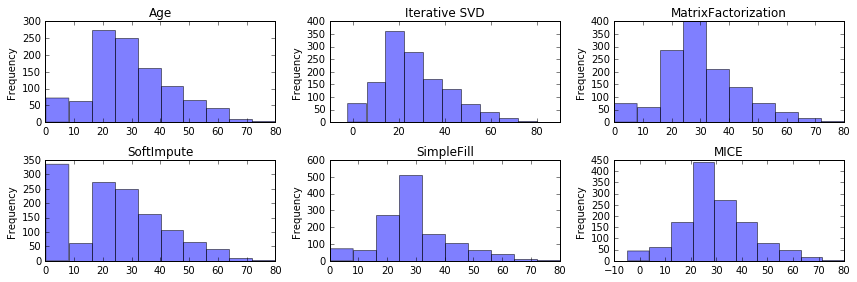

In [89]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 4))

full['Age'].plot.hist(alpha=0.5, ax=axes[0, 0], title = 'Age')
full['Age_IS'].plot.hist(alpha=0.5, ax=axes[0, 1], title = 'Iterative SVD')
full['Age_MF'].plot.hist(alpha=0.5, ax=axes[0, 2], title = 'MatrixFactorization')
full['Age_SI'].plot.hist(alpha=0.5, ax=axes[1, 0], title = 'SoftImpute')
full['Age_SF'].plot.hist(alpha=0.5, ax=axes[1, 1], title = 'SimpleFill')
full_dums['AgeFill'].plot.hist(alpha=0.5, ax=axes[1, 2], title = 'MICE')

fig.tight_layout()

In [115]:
# Did SoftImpute and IterativeSVD fill in the missing values with 0?

SI_values = full['Age_SI'][full['Age'].isnull()]
IS_values = full['Age_IS'][full['Age'].isnull()]
MF_values = full['Age_MF'][full['Age'].isnull()]
SF_values = full['Age_SF'][full['Age'].isnull()]

print(IS_values.describe())
print(MF_values.describe())
print(SI_values.describe())
print(SF_values.describe())

count    263.000000
mean       0.320987
std        0.096304
min        0.148530
25%        0.265662
50%        0.320775
75%        0.343480
max        0.786968
Name: Age_IS, dtype: float64
count    263.000000
mean       9.125542
std        4.707886
min        0.000000
25%        5.510048
50%        9.300503
75%       11.925666
max       28.940061
Name: Age_MF, dtype: float64
count    263.000000
mean       2.785520
std        0.860402
min        1.400583
25%        2.147847
50%        2.786330
75%        2.988088
max        7.166107
Name: Age_SI, dtype: float64
count    2.630000e+02
mean     2.988114e+01
std      1.174631e-13
min      2.988114e+01
25%      2.988114e+01
50%      2.988114e+01
75%      2.988114e+01
max      2.988114e+01
Name: Age_SF, dtype: float64


### Feature Engineering round 2

Now that we know everyone’s age, we can create a couple of new age-dependent variables: Child and Mother. A child will simply be someone under 18 years of age and a mother is a passenger who is 1) female, 2) is over 18, 3) has more than 0 children (no kidding!), and 4) does not have the title ‘Miss

In [12]:
# First we'll look at the relationship between age & survival
# For both male and female


In [13]:
# Create the column child, and indicate whether child or adult

# Show counts

In [14]:
# Adding Mother variable

All of the variables we care about should be taken care of and there should be no missing data. I’m going to double check just to be sure:

### Prediction

Our first step is to split the data back into the original test and training sets.

In [15]:
# check data

In [16]:
# Build a model using RandomForest

# Show model error

### Variable Importance

Let’s look at relative variable importance by plotting the mean decrease in Gini calculated across all trees.

In [17]:
# Get importance

# Create a rank variable based on importance

# Use ggplot2 to visualize the relative importance of variables

In [ ]:
# Predict using the test set

# Save the solution to a dataframe with two columns: PassengerId and Survived (prediction)

